In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import treescope as ts
import matplotlib.pyplot as plt
from typing import Callable, NamedTuple
from jaxtyping import Array, Float

In [2]:
class MLP(eqx.Module):
    layers: list[eqx.nn.Linear]
    activation: Callable
    def __init__(
        self, in_dim, out_dim, hidden=256, depth=4, activation=jax.nn.celu, seed=0
    ):
        dims = [in_dim] + [hidden] * (depth - 1) + [out_dim]
        keys = jr.split(jr.key(seed), depth)
        self.activation = activation
        self.layers = [
            eqx.nn.Linear(dim_in, dim_out, key=k)
            for k, dim_in, dim_out in zip(keys, dims[:-1], dims[1:])
        ]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [3]:
class Bounds(NamedTuple):
    value_lb: Float[Array, ""]
    value_ub: Float[Array, ""]
    grad_lb: Float[Array, ""]
    grad_ub: Float[Array, ""]

    def affine_transform(self, layer: eqx.nn.Linear):
        positive_weight = layer.weight.clip(min=0)
        negative_weight = layer.weight.clip(max=0)
        return Bounds(
            value_lb=layer.weight @ self.value_lb + layer.bias,
            value_ub=layer.weight @ self.value_ub + layer.bias,
            grad_lb=positive_weight @ self.grad_lb + negative_weight @ self.grad_ub,
            grad_ub=positive_weight @ self.grad_ub + negative_weight @ self.grad_lb,
        )

    def pointwise_activation(self, activation: Callable):
        # TODO implement for non monotone non convex
        activation_grad = jax.vmap(jax.grad(activation))
        activation_grad_min = activation_grad(self.value_lb)
        activation_grad_max = activation_grad(self.value_ub)
        # get the 4 possible limits for gradient bounds
        a = self.grad_lb * activation_grad_min
        b = self.grad_lb * activation_grad_max
        c = self.grad_ub * activation_grad_min
        d = self.grad_ub * activation_grad_max
        return Bounds(
            value_lb=activation(self.value_lb),
            value_ub=activation(self.value_ub),
            grad_lb=jnp.minimum(jnp.minimum(a, b), jnp.minimum(c, d)),
            grad_ub=jnp.maximum(jnp.maximum(a, b), jnp.maximum(c, d)),
        )

def get_bounds(model: MLP, center: Float[Array, "d"], radius: float):
    # TODO i dont think this is correct for multi-dim input
    bounds = Bounds(
        value_lb=center - radius,
        value_ub=center + radius,
        grad_lb=jnp.ones_like(center),
        grad_ub=jnp.ones_like(center),
    )
    for layer in model.layers[:-1]:
        bounds = bounds.affine_transform(layer)
        bounds = bounds.pointwise_activation(model.activation)
    bounds = bounds.affine_transform(model.layers[-1])
    return bounds

In [7]:
import optax
from tqdm import tqdm

def data(n=1024):
    x = jnp.linspace(-2, 2, n).reshape(-1, 1)
    y1 = jnp.where(x>0, jnp.sin(2*jnp.pi*x)/(2*jnp.pi)+x, 0.5+jnp.floor(x))
    y2 = jnp.where(x>0, jnp.cos(2*jnp.pi*x)/(2*jnp.pi)+x-1/(2*jnp.pi), 0.5+jnp.floor(x)) 
    y = jnp.concat([y1, y2], axis=-1)
    return x, y


def grad_lb(model, radius = 0.1):
    centers = jnp.arange(-4, 4, radius*2).reshape(-1, 1)
    bounds = jax.vmap(get_bounds, in_axes=(None, 0, None))(model, centers, radius)
    return bounds.grad_lb


optimizer = optax.adamw(3e-3)
x, y = data()


@eqx.filter_jit
def step(model, opt_state, k):
    def loss_fn(model):
        pred = jax.vmap(model)(x)
        mse = jnp.mean((pred - y) ** 2) 

        violations = jnp.clip(grad_lb(model), max=0)**2
        soft = k * jnp.sum(violations)
        return mse + soft, (mse, soft)

    (_, (loss, pen)), grad = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
    updates, opt_state = optimizer.update(grad, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss, pen

# soft penalty

Loss: 0.0033, Penalty: 0.0000: 100%|██████████| 3000/3000 [00:39<00:00, 75.87it/s]


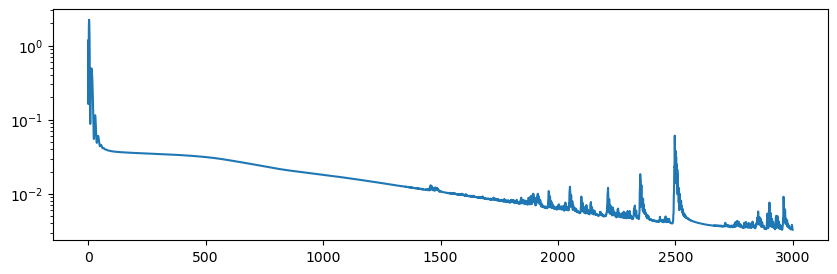

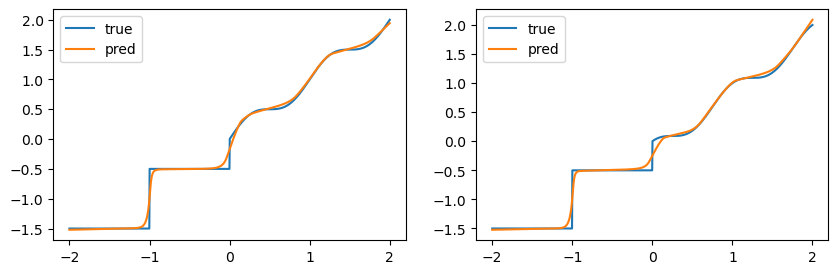

In [9]:
# initialize the model
model = MLP(in_dim=1, out_dim=2, activation=jax.nn.celu)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# train the model
losses = []
strength = 0.1 * jnp.ones(3000)
for k in (pbar:=tqdm(strength)):
    model, opt_state, loss, penalty = step(model, opt_state, k=k)
    pbar.set_description(f"Loss: {loss:.4f}, Penalty: {penalty:.4f}")
    losses.append(loss)
plt.figure(figsize=(10, 3))
plt.semilogy(losses)

# evaluate the model
x, y = data()
pred = jax.vmap(model)(x)
plt.figure(figsize=(10, 3))
for i in range(y.shape[-1]):
    plt.subplot(1, 2, i+1)
    plt.plot(x, y[:, i], label="true")
    plt.plot(x, pred[:, i], label="pred")
    plt.legend()

0.008502174


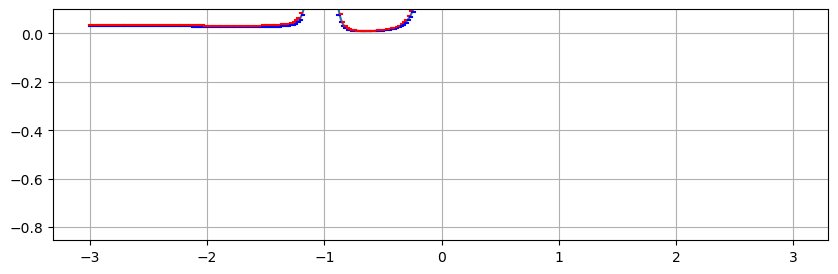

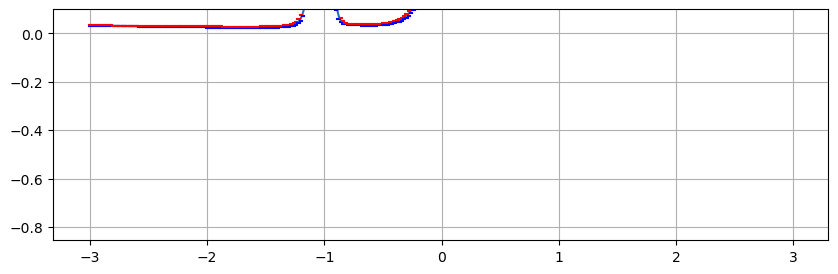

In [10]:
# evaluate the bounds
x = jnp.linspace(-3, 3, 100000).reshape(-1, 1)
J = jax.vmap(jax.jacobian(model))(x).squeeze(-1)

radius = 0.01
centers = jnp.arange(-3, 3, radius*2).reshape(-1, 1)
bounds = jax.vmap(get_bounds, in_axes=(None, 0, None))(model, centers, radius)

for d in range(J.shape[-1]):
    plt.figure(figsize=(10, 3))
    plt.plot(x, J[..., d])

    for i, c in enumerate(centers):
        plt.plot([c-radius, c+radius], [bounds.grad_lb[i, d]]*2, "b")
        plt.plot([c-radius, c+radius], [bounds.grad_ub[i, d]]*2, "r")
    plt.ylim(None, 0.1)
    plt.grid()
print(bounds.grad_lb.min())